<a href="https://colab.research.google.com/github/kavyajeetbora/PSENet.pytorch/blob/master/PSENet_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing softwares and other dependencies

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
!pip install pyclipper

     |████████████████████████████████| 133kB 2.7MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import shutil, os
os.chdir('/content')
directory = '/content/cloned-repo'
if os.path.exists(directory):
  shutil.rmtree(directory)

!git clone https://github.com/kavyajeetbora/PSENet.pytorch.git /content/cloned-repo
print("Cloned the repository")
os.chdir('/content/cloned-repo')
!ls

Cloning into '/content/cloned-repo'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 519 (delta 71), reused 0 (delta 0), pack-reused 400
Receiving objects: 100% (519/519), 8.75 MiB | 5.84 MiB/s, done.
Resolving deltas: 100% (265/265), done.
Cloned the repository
cal_recall  install_dependencies.sh  PSENet.ipynb	     train.py
config.py   LICENSE		     PSENet_predict.ipynb    utils
dataset     models		     PSENet_training.ipynb
eval.py     predict.py		     PSENet_trial_run.ipynb
imgs	    pse			     README.md


## Extracting the data and setting up the dataset

In [0]:
## unzipping the files
from zipfile import ZipFile

def unzip_files(file,output_dir):
  with ZipFile(file, 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall(output_dir)
  print('Extracted to',output_dir)

def make_directory(directory):
  if os.path.isdir(directory):
    shutil.rmtree(directory)
  
  os.mkdir(directory)
  print('Created a new directory')

test_data_zip = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/AI4Bharat Dataset/Test Set/real_Image_dataset_Detection.zip'

In [6]:
make_directory('Test Set')

Created a new directory


In [7]:
%%time
unzip_files(test_data_zip,'Test Set')

Extracted to Test Set
CPU times: user 539 ms, sys: 165 ms, total: 704 ms
Wall time: 4.48 s


In [9]:
print(len(os.listdir('Test Set/Images')))

428


In [10]:
print(len(os.listdir('Test Set/Annotations')))

428


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Training 

In [12]:
torch.device("cuda:{}".format(0))

device(type='cuda', index=0)

In [0]:
from pse import decode as pse_decode

In [0]:
def predict(net, img: str, device,long_size: int = 2240, scale=1):
  
  assert os.path.exists(img), 'file is not exists'
  img = cv2.imread(img)
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w = img.shape[:2]

  scale = long_size / max(h, w)
  img = cv2.resize(img, None, fx=scale, fy=scale)
  # 将图片由(w,h)变为(1,img_channel,h,w)
  tensor = transforms.ToTensor()(img)
  tensor = tensor.unsqueeze_(0)

  tensor = tensor.to(device)
  with torch.no_grad():
    torch.cuda.synchronize()
    start = time.time()
    preds = net(tensor)
    preds, boxes_list = pse_decode(preds[0], scale)
    scale = (preds.shape[1] / w, preds.shape[0] / h)
    # print(scale)
    # preds, boxes_list = decode(preds,num_pred=-1)
    if len(boxes_list):
        boxes_list = boxes_list / scale
    torch.cuda.synchronize()
    t = time.time() - start
  return preds, boxes_list, t

Predicting for image Test Set/Images/281.jpg
cuda:0
[[[525.77476965  69.22175966]
  [528.27308955  20.90780519]
  [574.60870607  23.30514024]
  [572.11038617  71.61909471]]

 [[588.91741071  30.9706258 ]
  [657.54464286  30.9706258 ]
  [657.54464286  74.07406433]
  [588.91741071  74.07406433]]

 [[447.51339286  30.9706258 ]
  [521.56696429  30.9706258 ]
  [521.56696429  68.00766284]
  [447.51339286  68.00766284]]

 [[386.16404969 228.52039946]
  [391.05871964  73.65152449]
  [718.84687805  84.01709468]
  [713.95224707 238.88596965]]

 [[437.70784378 336.85762642]
  [450.03867613 224.20477349]
  [690.19627108 250.50667754]
  [677.86543873 363.15953046]]

 [[597.53571429 275.54278416]
  [602.32366071 275.54278416]
  [602.32366071 281.9284802 ]
  [597.53571429 281.9284802 ]]

 [[602.32366071 260.53639847]
  [614.77232143 260.53639847]
  [614.77232143 282.24776501]
  [602.32366071 282.24776501]]

 [[477.66389574 431.70887057]
  [481.70380347 347.92568553]
  [676.37341363 357.31746045]
  [6

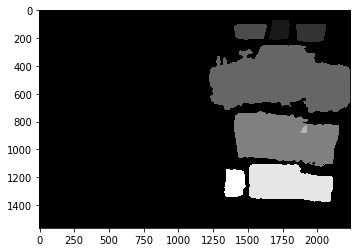

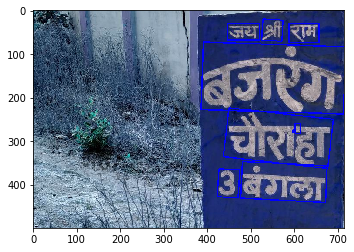

In [17]:
import time
import config
import cv2
from models import PSENet
from predict import _get_annotation, Pytorch_model
import matplotlib.pyplot as plt
from utils.utils import show_img, draw_bbox

os.environ['CUDA_VISIBLE_DEVICES'] = str('2')

model_path = '/content/drive/My Drive/PSENet_2/PSENet_resnet50.pth'

# model_path = 'output/psenet_icd2015_new_loss/final.pth'
image_root = 'Test Set/Images'
annotation_root = 'Test Set/Annotations'

Images = os.listdir(image_root)
Labels = os.listdir(annotation_root)
image_id = Images[np.random.randint(1,len(Images)+1)].split('.jpg')[0]

img_path = image_root+os.sep+'{}.jpg'.format(image_id)
label_path = annotation_root+os.sep+'{}.txt'.format(image_id)

print('Predicting for image',img_path)

label = _get_annotation(label_path)

# 初始化网络
net = PSENet(backbone='resnet50', pretrained=False, result_num=config.n)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
state_dict = torch.load(model_path, map_location=device)
net.load_state_dict(state_dict)
net = net.to(device)
# for i in range(100):
#     models.predict(img_path)
preds, boxes_list,t = predict(net,img_path,device)
print(boxes_list)
show_img(preds)
img = draw_bbox(img_path, boxes_list, color=(0, 0, 255))
cv2.imwrite('result.jpg', img)
# img = draw_bbox(img, label,color=(0,0,255))
show_img(img, color=True)

plt.show()